# Player Scoring Probability:
A simple model for scoring prices of football players based on open source data of Wyscout : https://www.kaggle.com/datasets/utkarshshri1016/wyscout-soccer-data . The main parts of this notebook are the importing of football events actions' data, logistic regression model on goals, importing players' data and finally a linear regression on players portion of goal expectancy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from statsmodels.formula.api import ols

## Importing and Cleaning of Events' Data:

### Importing the data of events for the top football league of England, Spain, Italy, Germany and France:

In [2]:
df_all = pd.read_json('events/events_England.json')
countries = ['Spain','Italy','Germany','France']
for i in countries:
    df = pd.read_json('events/events_'+i+'.json')
    df_all = pd.concat([df_all, df])

df_all.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


In [3]:
df_all.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


The tags column data includes extended information for each action, for shots (which are the actions which are analyzed here) the body part, the goal, shot on target and big chance. In the column with the name position, the positions of the shots are described, which are used for calculating the distance and the angle of a shot. The center of the target is defined as 0 for both axis and the anlge is calculated based on this point of reference by the function below.

Other interesting variables are calculated based on shots: on target, outside box, inside 6 yrds box, inside box (but not in 6 yrds box) and big chances.

In [4]:
def shots_classif(df):
    
    goals = np.zeros(len(df))
    SoT = np.zeros(len(df))
    headed = np.zeros(len(df))
    distance = np.zeros(len(df))
    inside_box = np.zeros(len(df))
    inside_s_box = np.zeros(len(df))
    angle = np.zeros(len(df))
    time_min = np.zeros(len(df))
    big_opp = np.zeros(len(df))

    df = df[df['subEventName'] != 'Penalty']

    for i in range(0,len(df)):
        y_in = (df.iloc[i]['positions'][0]['y']-50)*65/100
        x_in = (100-df.iloc[i]['positions'][0]['x'])*105/100
        distance[i] = np.sqrt(y_in**2+x_in**2)
        x_in += 0.0000001
        angle_1 = np.arctan(y_in/x_in)
        if angle_1<0:
            angle[i] = (90-(180+angle_1*180/np.pi-90))*np.pi/180
        else:
            angle[i] = (90-(180+angle_1*180/np.pi-90))*np.pi/180
    
        for j in df.iloc[i].tags:
            if j['id']==101:
                goals[i] = 1
            elif j['id']==403:
                headed[i] = 1
            elif j['id']==1801:
                SoT[i] = 1
            elif j['id']==201:
                big_opp[i] = 1

        if x_in<16.46:
            if y_in<40.23/2 and y_in>-40.23/2:
                inside_box[i] = 1

        if x_in<5.49:
            if y_in<18.29/2 and y_in>-18.29/2:
                inside_s_box[i] = 1 

        if df['matchPeriod'].iloc[i]=='1H':
            if df['eventSec'].iloc[i]>2700:
                time_min[i] = 45
            else:
                time_min[i] = df['eventSec'].iloc[i]//60
        else:
            time_min[i] = 45 + df['eventSec'].iloc[i]//60

    df_new = df.copy()
    df_new['minute'] = time_min
    df_new['Goal'] = goals
    df_new['Headed'] = headed
    df_new['SoT'] = SoT
    df_new['Out_Box'] = np.ones(len(inside_box)) - inside_box
    df_new['Inside_Box'] = inside_box-inside_s_box
    df_new['In_Sm_Box'] = inside_s_box
    df_new['Distance'] = distance
    df_new['Angle'] = abs(angle*180/np.pi)
    df_new['Big_Chance'] = big_opp

    df_new = df_new.drop(['subEventName','eventId','tags','positions','eventName','subEventId','id','matchPeriod','eventSec'], axis=1)

    return df_new
    
#df_shots = shots_classif(df_all[df_all['subEventName']=='Shot'].iloc[:])

In [5]:
df_shots = shots_classif(df_all[df_all['subEventName']=='Shot'].iloc[:])
df_shots.head()

,playerId,matchId,teamId,minute,Goal,Headed,SoT,Out_Box,Inside_Box,In_Sm_Box,Distance,Angle,Big_Chance
46,25413,2499719,1609,1.0,1.0,0.0,1.0,0.0,1.0,0.0,13.891814,24.904769,1.0
62,26150,2499719,1631,2.0,0.0,0.0,0.0,0.0,1.0,0.0,15.803560,4.718479,1.0
91,14763,2499719,1631,4.0,1.0,1.0,1.0,0.0,0.0,1.0,4.396590,17.198541,1.0
128,7868,2499719,1609,7.0,0.0,0.0,0.0,1.0,0.0,0.0,22.805811,28.981398,1.0
249,7868,2499719,1609,13.0,0.0,0.0,1.0,1.0,0.0,0.0,29.292704,26.346366,1.0


## Logistic Regression For Scoring Probability Of Shots:

A logistic regression will be applied to shots leading to goal. The model is based on distance, angle, if the shot was a header and a big chance variables.                     

The metric which is the goal of this model is the goal expectancy, which is the mean of a poisson distribution based on the probability of a shot to lead to a goal. The logistic regression predicts the probability of a shot to lead to a goal, but for calculating the overall probability of goals in a game is not reasonable to add the probability of all shots since it will lead to unreasonable values. The goals in a football in general follow the poisson distribution (with a small dependancy between home team and away team goals). So the probabillity of the model will be transform to ExG based on:
$$
Ex_{G} = -ln(1-Prob_{Goal})
$$

In [6]:
data = np.zeros((len(df_shots),4))
data[:,0] = (df_shots["Angle"]-min(df_shots["Angle"]))/(max(df_shots["Angle"])-min(df_shots["Angle"]))
data[:,1] = (df_shots["Distance"]-min(df_shots["Distance"]))/(max(df_shots["Distance"])-min(df_shots["Distance"]))
data[:,2] = df_shots["Headed"]
data[:,3] = df_shots['Big_Chance']

X_train, X_test, y_train, y_test = train_test_split(data,df_shots["Goal"] , random_state=10, test_size=0.2,shuffle=True) 
lr_model_1 = LogisticRegression()
lr_model_1.fit(X_train, y_train)
b = lr_model_1.intercept_
w = lr_model_1.coef_
print(f"w = {w:}, b = {b[0]}")
print("Accuracy on training set:", lr_model_1.score(X_test, y_test))

w = [[ -1.05735548 -13.00778387  -0.93224517   3.85197681]], b = -3.321085103230918
Accuracy on training set: 0.8937353268256518


### Visualising the model's results:

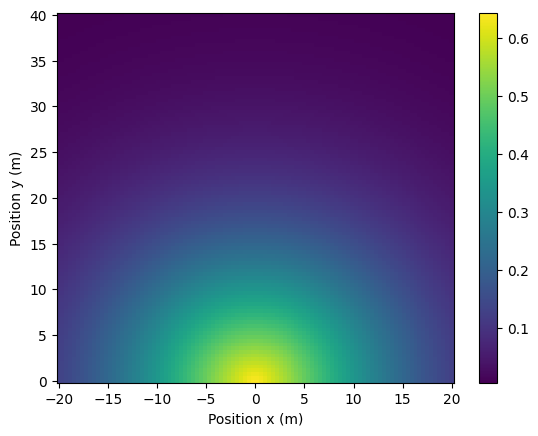

In [7]:
x_grid = np.linspace(-20,20,100)
y_grid = np.linspace(0,40,100)
X, Y = np.meshgrid(x_grid,y_grid)
Z = np.zeros((100,100))

for i in range(100):
   for j in range(100):
        a = np.abs(np.arctan(Y[i,j]/X[i,j]))/90
        d = (np.sqrt(X[i,j]**2+Y[i,j]**2)-0.65)/(103.95203220716756-0.65)
        Z[i,j] = lr_model_1.predict_proba(np.array([a,d,0,1]).reshape(1, -1))[:,1][0]

plt.pcolor(X, Y, Z)
plt.colorbar()
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')
plt.show()

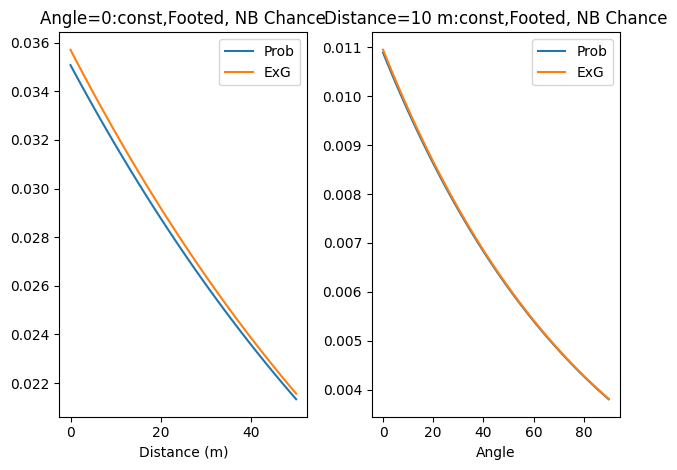

In [8]:
data_plot = np.zeros((100,4))
distance = np.linspace(0,50,100)
angle = np.linspace(0,90,100)
data_plot[:,0] = (distance-0.65)/(104-0.65)
y_dist = lr_model_1.predict_proba(data_plot)[:,1]
data_plot[:,1] = 1
y_dist_head = lr_model_1.predict_proba(data_plot)[:,1]
data_plot[:,1] = 0

data_plot[:,0] = angle/90
data_plot[:,1] = (10-0.65)/(103-0.65)
y_angle = lr_model_1.predict_proba(data_plot)[:,1]
y_angle_head = lr_model_1.predict_proba(data_plot)[:,1]

fig, (ax1, ax2) = plt.subplots(1,2)
#axs[0].plot(x, y)
ax1.set_title('Angle=0:const,Footed, NB Chance')
ax1.plot(distance,y_dist)
ax1.plot(distance,-np.log(1-y_dist))
ax1.set_xlabel('Distance (m)')
ax1.legend(['Prob','ExG'])


ax2.set_title('Distance=10 m:const,Footed, NB Chance')
ax2.plot(angle,y_angle)
ax2.plot(angle,-np.log(1-y_angle))
ax2.set_xlabel('Angle')
ax2.legend(['Prob','ExG'])
plt.tight_layout()
plt.show()

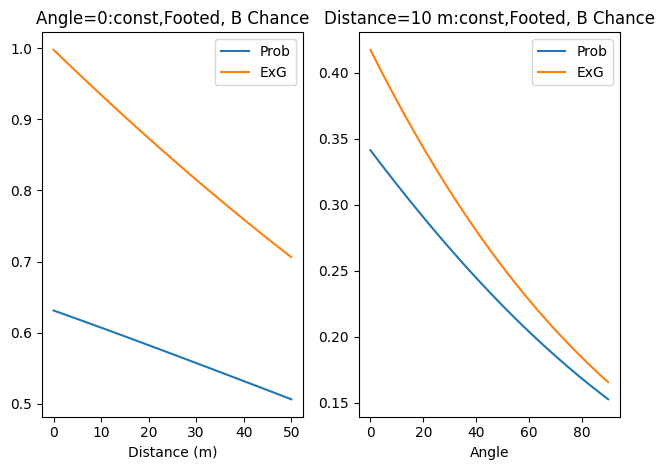

In [9]:
data_plot = np.zeros((100,4))
data_plot[:,3] = 1
distance = np.linspace(0,50,100)
angle = np.linspace(0,90,100)
data_plot[:,0] = (distance-0.65)/(104-0.65)
y_dist = lr_model_1.predict_proba(data_plot)[:,1]
data_plot[:,1] = 1
y_dist_head = lr_model_1.predict_proba(data_plot)[:,1]
data_plot[:,1] = 0

data_plot[:,0] = angle/90
data_plot[:,1] = (10-0.65)/(103-0.65)
y_angle = lr_model_1.predict_proba(data_plot)[:,1]
y_angle_head = lr_model_1.predict_proba(data_plot)[:,1]

fig, (ax1, ax2) = plt.subplots(1,2)
#axs[0].plot(x, y)
ax1.set_title('Angle=0:const,Footed, B Chance')
ax1.plot(distance,y_dist)
ax1.plot(distance,-np.log(1-y_dist))
ax1.set_xlabel('Distance (m)')
ax1.legend(['Prob','ExG'])
ax2.set_title('Distance=10 m:const,Footed, B Chance')
ax2.plot(angle,y_angle)
ax2.plot(angle,-np.log(1-y_angle))
ax2.set_xlabel('Angle')
ax2.legend(['Prob','ExG'])
plt.tight_layout()
plt.show()

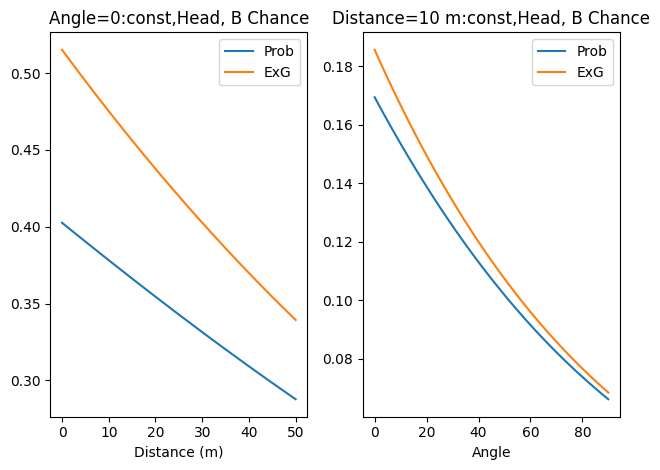

In [10]:
data_plot = np.zeros((100,4))
data_plot[:,3] = 1
data_plot[:,2] = 1
distance = np.linspace(0,50,100)
angle = np.linspace(0,90,100)
data_plot[:,0] = (distance-0.65)/(104-0.65)
y_dist = lr_model_1.predict_proba(data_plot)[:,1]
data_plot[:,1] = 1
y_dist_head = lr_model_1.predict_proba(data_plot)[:,1]
data_plot[:,1] = 0

data_plot[:,0] = angle/90
data_plot[:,1] = (10-0.65)/(103-0.65)
y_angle = lr_model_1.predict_proba(data_plot)[:,1]
y_angle_head = lr_model_1.predict_proba(data_plot)[:,1]

fig, (ax1, ax2) = plt.subplots(1,2)
#axs[0].plot(x, y)
ax1.set_title('Angle=0:const,Head, B Chance')
ax1.plot(distance,y_dist)
ax1.plot(distance,-np.log(1-y_dist))
ax1.set_xlabel('Distance (m)')
ax1.legend(['Prob','ExG'])
ax2.set_title('Distance=10 m:const,Head, B Chance')
ax2.plot(angle,y_angle)
ax2.plot(angle,-np.log(1-y_angle))
ax2.set_xlabel('Angle')
ax2.legend(['Prob','ExG'])
plt.tight_layout()
plt.show()

In the plots above it is obvious that if a shot is not a big chance its probability to lead to a goal is extremely low even if it is very close to the target. For the case of big chance headers have much lower probability to lead to a goal compared to footed shots, while the probability of a shot to lead to a goal shows an almost linear relation to distance.

Below the goal expectancy is calculated for each shot in the dataset and then the overall sum of the expectancies of each team and player are saved for later with also the portion of shots outside the box, inside the box and inside the 6 yrds box for each player.

In [11]:
df_shots_2 = df_shots.copy()
df_shots_2['EXG'] = lr_model_1.predict_proba(data)[:,1]
df_shots_2['Shots'] = np.ones(len(df_shots_2['EXG']))
df_shots_2['EXG_Head'] = df_shots_2['Headed']*df_shots_2['EXG']
df_shots_2['EXG_Out_Box'] = df_shots_2['Out_Box']*df_shots_2['EXG']
players_ExG = df_shots_2.groupby('playerId', as_index=False).agg({'EXG':'sum','Out_Box':'mean','Inside_Box':'mean','Headed':'mean',
                                                                  'SoT':'mean','EXG_Head':'sum','EXG_Out_Box':'sum','Shots':'sum'})
teams_ExG = df_shots_2.groupby('teamId',as_index=False).agg({'EXG':'sum'})
teams_ExG = teams_ExG.rename(columns={'EXG': 'EXG_T'})

## Adding Players' Data:

### Here players' data can be inserted for further analysis, such as their position and their games/playing time. Based on these additional data with the help also from the previous ExG model, a model can be constracted for players scoring probabillity.

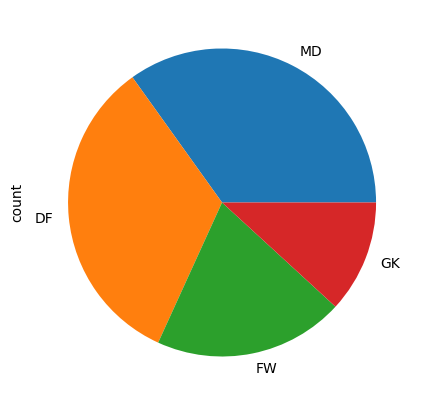

In [14]:
df_teams = pd.read_json('teams.json')
df_players = pd.read_json('players.json')
df_players = df_players.drop(['passportArea', 'weight', 'middleName', 'birthDate', 'birthArea', 'firstName',
                              'lastName','currentNationalTeamId'], axis=1)

df_players = df_players.rename(columns={'currentTeamId': 'teamId', 'wyId': 'playerId'})
roles = []
for i in range(0,len(df_players)):
    roles.append(df_players["role"][i]['code2'])

df_players['role'] = roles
df_players['role'].value_counts().plot.pie(figsize=(5, 5))
df_players.head()
df_players = df_players[df_players['role']!='GK']

In [15]:
df_matches_all = pd.read_json('matches/matches_England.json')
countries = ['Spain','Italy','Germany','France']
for i in countries:
    df = pd.read_json('matches/matches_'+i+'.json')
    df_matches_all = pd.concat([df_matches_all, df])

df_matches_all.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385704, 'role': 'referee'}, {'r...",Regular,364
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381853, 'role': 'referee'}, {'r...",Regular,364


The column named teamsData contains the starting lineup of each game and teams participating although the format is not optimal for easy use. Below the number of games each player started is retrieved.

In [16]:
game_id = np.unique(df_all['matchId']) #==2499719

team_1 = np.zeros(len(game_id))
team_2 = np.zeros(len(game_id))
k = 0
for i in game_id:
    team_1[k],team_2[k] = np.unique(df_all[df_all['matchId']==i]['teamId'])
    k += 1


match_info = pd.DataFrame([])
match_info['team_1'] = np.asarray(team_1,dtype="int") 
match_info['team_2'] = np.asarray(team_2,dtype="int") 
match_info['match_id'] = game_id

In [17]:
players_started = []
k = 0
for i in range(0,len(df_matches_all)): #len(team_1)):
    id_1 = str(int(match_info[match_info['match_id']== df_matches_all['wyId'].iloc[k]]['team_1']))
    id_2 = str(int(match_info[match_info['match_id']== df_matches_all['wyId'].iloc[k]]['team_2']))
    for j in range(0,11):
        players_started.append(df_matches_all['teamsData'].iloc[k][id_1]['formation']['lineup'][j]['playerId'])
        players_started.append(df_matches_all['teamsData'].iloc[k][id_2]['formation']['lineup'][j]['playerId'])
    k += 1

C:\Users\Eleftherios\AppData\Local\Temp\ipykernel_20636\569464126.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  id_1 = str(int(match_info[match_info['match_id']== df_matches_all['wyId'].iloc[k]]['team_1']))
C:\Users\Eleftherios\AppData\Local\Temp\ipykernel_20636\569464126.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  id_2 = str(int(match_info[match_info['match_id']== df_matches_all['wyId'].iloc[k]]['team_2']))


In [18]:
players_started_id = np.unique(players_started)
k = 0
players_started_count = np.zeros(len(players_started_id))
for i in players_started_id:
    players_started_count[k] = players_started.count(i)
    k += 1

players_started_count


player_time = pd.DataFrame([])
player_time['playerId'] = players_started_id
player_time['games'] = np.asarray(players_started_count,dtype="int") 

player_time

,playerId,games
0,33,1
1,36,13
2,38,4
3,45,3
4,48,36
...,...,...
2365,520163,1
2366,520617,1
2367,523089,4
2368,551398,1


## The only position classification based on the players dataset are defender (DF), midfielder (MD) and forward (FW) beside the goalkeepers (GK). A more precise clasification of players position can be calculated based on their data clasification and their average position in the pitch through K-means classification.

In [19]:
df_new = df_all[['playerId', 'positions','eventName']].copy()

y_in = np.zeros(len(df_new))
x_in = np.zeros(len(df_new))
for i in range(0,len(df_new)):
    y_in[i] = df_new.iloc[i]['positions'][0]['y']
    x_in[i] = df_new.iloc[i]['positions'][0]['x']

df_new['x_in'] = x_in
df_new['y_in'] = y_in
df_new = df_new.drop(['positions','eventName'], axis=1)
df_new.head()

,playerId,x_in,y_in
0,25413,49.0,49.0
1,370224,31.0,78.0
2,3319,51.0,75.0
3,120339,35.0,71.0
4,167145,41.0,95.0


In [20]:
pos = df_new.groupby('playerId').agg({'x_in':'mean','y_in':'mean'})
pos = pd.merge(pos, df_players[['playerId','role']], on='playerId')
pos = pd.merge(pos, player_time, on='playerId')
pos.head()

,playerId,x_in,y_in,role,games
0,36,38.978313,67.576707,DF,13
1,38,52.850543,17.029891,DF,4
2,45,39.127660,83.787234,DF,3
3,48,39.327439,28.460360,DF,36
4,54,62.458627,52.401115,MD,37


In [21]:
def k_means_test(data,cluster_number = 3):
    inertias = []

    for i in range(1,20):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    plt.plot(range(1,20), np.log(inertias), marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

    inertias = []
    min_inertia = 1000
    for i in range(0,100):
        kmeans = KMeans(n_clusters=cluster_number,random_state = i)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        if min_inertia>inertias[i]:
            min_inertia = inertias[i]
            best_labels = kmeans.labels_
            center_cluster = kmeans.cluster_centers_
    plt.scatter(data[:,0], data[:,1], c=best_labels)
    for i in range(0,cluster_number):
        plt.scatter(center_cluster[:,0],center_cluster[:,1],color = "b")
        plt.annotate(i, (center_cluster[i,0], center_cluster[i,1]),color = 'b', fontsize=20)
    plt.show()

    return best_labels

In [22]:
def assign_pos(df = pos,df_pl = df_players,cluster_number = 3):
    df_pl = df_pl[df_pl['playerId'].isin(pos.index)]

    print(len(df_players),len(pos))
    data_pos = np.zeros((len(pos['x_in']),5))
    data_pos[:,0] = (np.array(pos['x_in'])-min(np.array(pos['x_in'])))/(max(np.array(pos['x_in']))-min(np.array(pos['x_in'])))
    data_pos[:,1] = (np.array(pos['y_in'])-min(np.array(pos['y_in'])))/(max(np.array(pos['y_in']))-min(np.array(pos['y_in'])))
    data_pos[:,2] = (pos['role']=='DF')
    data_pos[:,3] = (pos['role']=='MD')
    data_pos[:,4] = (pos['role']=='FW')
    best_labels = k_means_test(data = data_pos,cluster_number = cluster_number)

    out_pos_data = np.zeros((len(best_labels),2))
    out_pos_data[:,0] = pos['playerId']
    out_pos_data[:,1] = best_labels
    
    return out_pos_data

3177 2174


C:\Users\Eleftherios\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Eleftherios\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


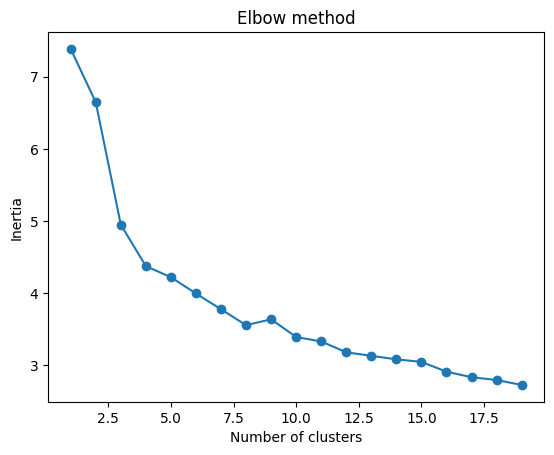

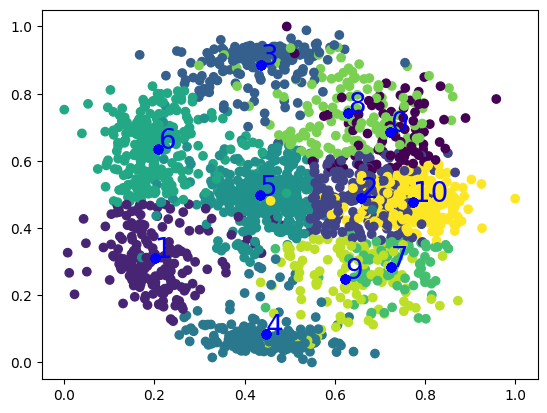

In [23]:
out_pos_data = assign_pos(df = pos, df_pl = df_players,cluster_number = 11)

The positions of players are visually clasified to the main football roles: CB, SB, DFMD, ACMD,,MDW, FWW, CF.

In [24]:
ids = out_pos_data[:,0]
ex_pos = np.empty(len(out_pos_data), dtype='<U5')

pos_numb_ind = np.array([1,6,3,4,5,2,8,9,0,7,10])
pos_ind = ['CB','CB','SB','SB','DCMD','ACMD','MDW','MDW','FWW','FWW','CF']
k = 0

for i in pos_numb_ind:
    ex_pos[out_pos_data[:,1] == pos_numb_ind[k]] = pos_ind[k]
    k += 1

df_players_upd = pd.DataFrame([])
df_players_upd['playerId'] = ids
df_players_upd['role_new'] = ex_pos
df_players_upd = pd.merge(df_players, df_players_upd, on='playerId')
df_players_upd = df_players_upd.drop(['height','role','foot','shortName'],axis = 1)

df_players_upd

,teamId,playerId,role_new
0,3775,393228,CB
1,683,32793,DCMD
2,2975,393247,CB
3,1624,36,CB
4,1624,48,CB
...,...,...,...
2169,2594,433100,CB
2170,2463,448127,MDW
2171,2594,471947,FWW
2172,2463,520617,CB


In [25]:
df_players_upd2 = pd.merge(df_players_upd, players_ExG, on='playerId')
df_players_upd2 = pd.merge(df_players_upd2, teams_ExG, on='teamId')
df_players_upd2 = pd.merge(df_players_upd2, player_time, on='playerId')

#Filtering players with less than 5 starting lineup positions.
df_players_upd2 = df_players_upd2[df_players_upd2['games']>5]

df_players_upd2['EXG_T'] = df_players_upd2['EXG_T']/38
df_players_upd2['EXG'] = df_players_upd2['EXG']/df_players_upd2['games']
df_players_upd2['EXG'] = df_players_upd2['EXG']/df_players_upd2['EXG_T']
df_players_upd2

,teamId,playerId,role_new,EXG,Out_Box,Inside_Box,Headed,SoT,EXG_Head,EXG_Out_Box,Shots,EXG_T,games
0,3775,393228,CB,0.035599,0.333333,0.500000,0.333333,0.166667,0.178769,0.001602,6.0,1.140947,13
1,1624,36,CB,0.036870,0.600000,0.400000,0.200000,0.100000,0.312920,0.197782,10.0,1.541607,13
2,1624,48,CB,0.014292,0.608696,0.391304,0.173913,0.130435,0.116021,0.159572,23.0,1.541607,36
3,3783,229427,CB,0.051841,0.153846,0.846154,0.769231,0.076923,1.174161,0.001968,13.0,0.969361,28
4,1624,54,ACMD,0.121738,0.600000,0.375000,0.012500,0.412500,0.108128,1.245077,80.0,1.541607,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,2460,290119,CB,0.073426,0.235294,0.647059,0.411765,0.176471,0.748981,0.105020,17.0,0.893139,34
1870,674,292654,CB,0.051818,0.000000,0.333333,1.000000,0.333333,0.465547,0.000000,3.0,1.123034,8
1871,3774,325781,ACMD,0.109290,0.709677,0.225806,0.032258,0.354839,0.122213,0.620540,31.0,1.113024,18
1872,3775,326946,SB,0.009583,0.500000,0.500000,0.500000,0.000000,0.000689,0.075846,2.0,1.140947,7


## Linear regression on players portion of goal expectancy.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EXG   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     592.5
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        07:29:59   Log-Likelihood:                 2192.2
No. Observations:                1640   AIC:                            -4370.
Df Residuals:                    1633   BIC:                            -4333.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
C(role_new)[ACMD]     0.1279      0.005     26.558      0.000       0.118       0.137
C(role_new)[CB]       0.0436      0.003     12.944      0.000       0.037       0.050
C(role_new)[CF]       0.3061      0.004     73.510      0.000       0.298       0.314
C(role_new)[DCMD]     0.0496      0.004     13.110      0.000       0.042       0.057
C(role_new)[FWW]      0.1955      0.006     34.302      0.000       0.184       0.207
C(role_new)[MDW]      0.1043      0.005     22.093      0.000       0.095       0.114
C(role_new)[SB]       0.0290      0.004      7.661      0.000       0.022       0.036
==============================================================================
Omnibus:                      617.077   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5912.991
Skew:                           1.483   Prob(JB):                         0.00
Kurtosis:                      11.817   Cond. No.                         1.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

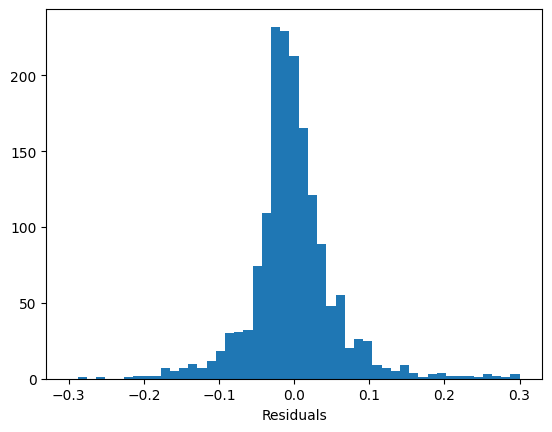

In [26]:
fit_simple = ols('EXG ~ C(role_new)-1', data=df_players_upd2).fit() 
bins = np.linspace(-0.3,0.3)
plt.hist(fit_simple.resid,bins=bins)
plt.xlabel('Residuals')
fit_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EXG   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     415.8
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        07:30:00   Log-Likelihood:                 2283.7
No. Observations:                1640   AIC:                            -4545.
Df Residuals:                    1629   BIC:                            -4486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
C(role_new)[ACMD]     0.2097      0.017     12.709      0.000       0.177       0.242
C(role_new)[CB]       0.0928      0.016      5.949      0.000       0.062       0.123
C(role_new)[CF]       0.3627      0.016     22.907      0.000       0.332       0.394
C(role_new)[DCMD]     0.1448      0.016      8.825      0.000       0.113       0.177
C(role_new)[FWW]      0.2644      0.017     15.997      0.000       0.232       0.297
C(role_new)[MDW]      0.1855      0.016     11.269      0.000       0.153       0.218
C(role_new)[SB]       0.1154      0.016      7.130      0.000       0.084       0.147
Out_Box              -0.1281      0.016     -7.877      0.000      -0.160      -0.096
Inside_Box           -0.0539      0.016     -3.369      0.001      -0.085      -0.023
Headed                0.0132      0.010      1.305      0.192      -0.007       0.033
SoT                   0.0195      0.010      2.026      0.043       0.001       0.038
==============================================================================
Omnibus:                      669.514   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6886.206
Skew:                           1.618   Prob(JB):                         0.00
Kurtosis:                      12.503   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

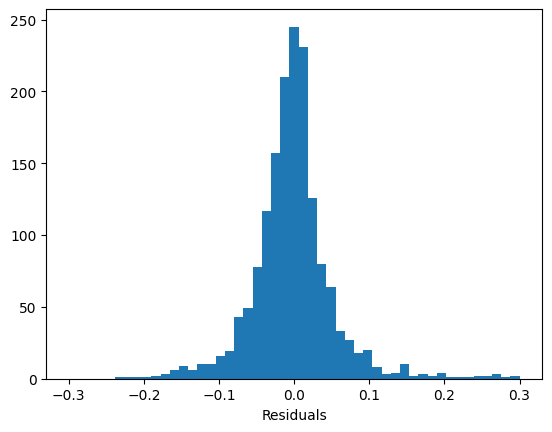

In [27]:
fit_compl = ols('EXG ~  C(role_new) + Out_Box + Inside_Box + Headed	+ SoT - 1', data=df_players_upd2).fit() 
bins = np.linspace(-0.3,0.3)
plt.hist(fit_compl.resid,bins=bins)
plt.xlabel('Residuals')
fit_compl.summary()

For both cases residuals seem to follow a normal distribution around 0 with high precision and accuracy. 
The model with the additional variables performs better but the statistical significance of Headed is not enogh and thus
it has to be excluded. The SoT variable is excluded as well for the same reason after regressing the same case without headed. The 
final model is presented below.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EXG   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     517.9
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        07:30:00   Log-Likelihood:                 2280.9
No. Observations:                1640   AIC:                            -4544.
Df Residuals:                    1631   BIC:                            -4495.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
C(role_new)[ACMD]     0.2232      0.015     14.456      0.000       0.193       0.253
C(role_new)[CB]       0.1084      0.014      7.836      0.000       0.081       0.136
C(role_new)[CF]       0.3770      0.015     25.840      0.000       0.348       0.406
C(role_new)[DCMD]     0.1589      0.015     10.411      0.000       0.129       0.189
C(role_new)[FWW]      0.2780      0.015     18.013      0.000       0.248       0.308
C(role_new)[MDW]      0.1988      0.015     12.878      0.000       0.169       0.229
C(role_new)[SB]       0.1284      0.015      8.429      0.000       0.098       0.158
Out_Box              -0.1387      0.016     -8.933      0.000      -0.169      -0.108
Inside_Box           -0.0550      0.016     -3.447      0.001      -0.086      -0.024
==============================================================================
Omnibus:                      659.256   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6676.708
Skew:                           1.592   Prob(JB):                         0.00
Kurtosis:                      12.358   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

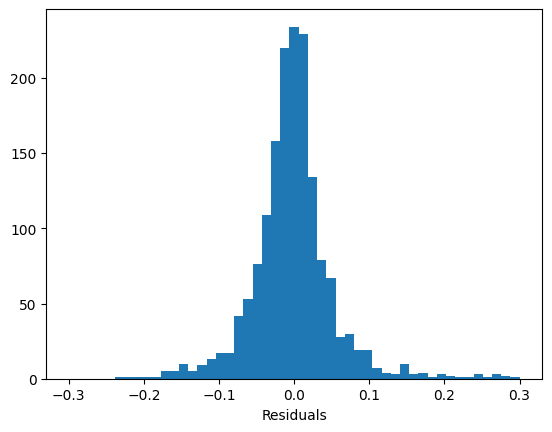

In [28]:
fit_compl = ols('EXG ~  C(role_new) + Out_Box + Inside_Box  - 1', data=df_players_upd2).fit() 
bins = np.linspace(-0.3,0.3)
plt.hist(fit_compl.resid,bins=bins)
plt.xlabel('Residuals')
fit_compl.summary()